<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/Monitoring%20Data%20and%20Model%20Drift%20in%20your%20MLOps%20pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monitoring Data and Model Drift in your MLOps pipeline

https://www.persistent.com/blogs/monitoring-data-and-model-drift-in-your-mlops-pipeline/

In [1]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/sj2503/drift-detection-project

Cloning into 'drift-detection-project'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


# Installing and Importing Required Libraries:

In [9]:
!pip install mlflow
!pip install shap
!pip install evidently
!pip install alibi-detect

     |████████████████████████████████| 207 kB 12.5 MB/s 
     |████████████████████████████████| 2.8 MB 69.7 MB/s 
     |████████████████████████████████| 4.8 MB 32.6 MB/s 
     |████████████████████████████████| 454.4 MB 8.9 kB/s 
     |████████████████████████████████| 1.2 MB 70.1 MB/s 
     |████████████████████████████████| 4.0 MB 58.6 MB/s 
     |████████████████████████████████| 462 kB 54.2 MB/s 
     |████████████████████████████████| 895 kB 61.3 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 3.3 MB 55.1 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.39.0
    Uninstalling grpcio-1.39.0:
      Successfully uninstalled grpcio-1.39.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorflow-probability
    Found e

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.feather_format import read_feather
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from evidently.dashboard import Dashboard
from evidently.tabs import ClassificationPerformanceTab, DataDriftTab

import mlflow
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Defining mlfow_run Function:

In [22]:
def create_mlflow_run():
        print()
        print("MLFlow run started...")
        # get the dataset name
        p_dataset = 'data.csv'
        p_model = sys.argv[4] if len(sys.argv) > 4 else 'RandomForestClassifier'
        print()
        print("Loading dataset %s ..."%p_dataset)

        # ##### LOAD THE DATA #####
        data = pd.read_csv(p_dataset)
        print() 
        print("Pre-processing & Cleansing...")
        data = data.drop(columns=['Loan_ID']) ## Dropping Loan ID
        categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
        numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
        numerical_data = data[numerical_columns].copy()
        categorical_data = data[categorical_columns].copy()
        categorical_data["Gender"] = categorical_data["Gender"].map({"Male":1,"Female":0})
        categorical_data["Married"] = categorical_data["Married"].map({"Yes":1,"No":0})
        categorical_data["Dependents"] = categorical_data["Dependents"].map({"0":0,"1":1,"2":2,"3+":3})
        categorical_data["Education"] = categorical_data["Education"].map({"Graduate":1, "Not Graduate":0})
        categorical_data["Self_Employed"] = categorical_data["Self_Employed"].map({"Yes":1, "No":0})
        categorical_data["Loan_Amount_Term"] = categorical_data["Loan_Amount_Term"].map({12:0,36:1,60:2,84:3,120:4,180:5,240:6,300:7,360:8,480:9})
        categorical_data["Property_Area"] = categorical_data["Property_Area"].map({"Urban":2,"Semiurban":1, "Rural":0})
        categorical_data = categorical_data.to_numpy().astype(int)

        # ##### PLOT CATEGORICAL COLUMNS #####
        sns.set(style="white", context="talk")
        sns.color_palette("rocket")
        fig,axes = plt.subplots(4,2,figsize=(15,25))
        for idx,cat_col in enumerate(categorical_columns):
            row,col = idx//2,idx%2
            sns.countplot(x=cat_col, data=data, hue='Loan_Status', ax=axes[row,col])
        plt.subplots_adjust(hspace=0.5)
        fig.savefig('CATEGORICAL_DATA.png', bbox_inches='tight')

        # ##### PLOT NUMERIC COLUMNS #####
        fig,axes = plt.subplots(1,3,figsize=(17,5))
        for idx,cat_col in enumerate(numerical_columns):
            sns.boxplot(y=cat_col, data=data, x='Loan_Status',ax=axes[idx])
        plt.subplots_adjust(hspace=0.5)
        fig.savefig('NUMERIC_DATA.png', bbox_inches='tight')

        ##### FEATURE ENGINEERING #####
        print()
        print("Feature Engineering...")
        train_df_encoded = pd.get_dummies(data,drop_first=True)
        X = train_df_encoded.drop(columns='Loan_Status_Y')
        X_columns = X.columns
        y = train_df_encoded['Loan_Status_Y']
        X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25)

        imp = SimpleImputer(strategy='mean')
        imp_train = imp.fit(X_train)
        X_train = imp_train.transform(X_train)
        X_test_tmp = X_test.copy()
        X_test = imp_train.transform(X_test)
        X_test_df = pd.DataFrame(X_test, columns=X_columns)
        imp_numerical_data = imp.fit(numerical_data)
        numerical_data = imp_numerical_data.transform(numerical_data)

        # ##### BUILD ML MODEL #####
        print()
        print("Building the ML Model...")
        model = RandomForestClassifier(n_estimators=50,max_depth=5)
        model.fit(X_train,y_train)
        # print(list(zip(train_df_encoded.columns, model.feature_importances_)))       
        # cross-validation
        xval_scores = cross_val_score(model, X_train, y_train, cv=10)   

        # ##### METRICS #####
        print()
        print("Model evaluation...")
        y_pred = model.predict(X_train)
        train_f1 = f1_score(y_train,y_pred)
        train_acc = accuracy_score(y_train,y_pred)
        y_pred = model.predict(X_test)
        test_f1 = f1_score(y_test,y_pred)
        test_acc = accuracy_score(y_test,y_pred)

        plt.figure(figsize=(30,15))
        plot_confusion_matrix(model, X_test, y_test,
        display_labels=['Approved', 'Rejected'],
        cmap=plt.cm.Blues,
        normalize='pred')
        plt.savefig('CONFUSION_MATRIX.png', bbox_inches='tight')

        # ##### EXPLANATIONS #####
        print()
        print("Generating explanations...")
        plt.figure(figsize=(30,15))
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test_tmp, show=False, class_names=['Rejected','Approved'])
        plt.savefig('SHAP_EXPLANATIONS.png', bbox_inches='tight')


        # ##### LOG THE RUN #####
        with mlflow.start_run():
            mlflow.log_param('DATA CATALOG ENTRY', p_dataset)
            mlflow.log_param('MODEL CATALOG ENTRY', p_model)
            mlflow.log_artifact('CATEGORICAL_DATA.png')
            mlflow.log_artifact('NUMERIC_DATA.png')
            mlflow.log_artifact('CONFUSION_MATRIX.png')
            mlflow.log_metric('TRAINING F1 SCORE', train_f1)
            mlflow.log_metric('TESTING F1 SCORE', test_f1)
            mlflow.log_metric('TRAINING ACCURACY', train_acc)
            mlflow.log_metric('TESTING ACCURACY', test_acc)

            print('--'*10)
            print('TRAINING ACCURACY', train_acc)
            print('TESTING ACCURACY', test_acc)
            print('--'*10)
            for score in xval_scores:
                mlflow.log_metric('CROSS VALIDATION SCORE', score)
            mlflow.log_artifact('SHAP_EXPLANATIONS.png')
            print()
            print("MLFlow run completed!")

        # ##### DRIFT GENERATOR DATASET ######
        print()
        print("Creating dataset with data drift...")
        X_test_df_old = X_test_df.copy()
        for i in range(0,X_test_df.shape[0]):
                ApplicantIncome_Change = np.random.randint(-60,-20)
                LoanAmount_Change = np.random.randint(30,71)
                CoapplicantIncome_Change = np.random.randint(-60,-20)
                X_test_df.loc[i,"ApplicantIncome"] = (1 + (ApplicantIncome_Change/100)) * X_test_df.loc[i,"ApplicantIncome"]
                if(X_test_df.loc[i,"CoapplicantIncome"]!=0):
                        X_test_df.loc[i,"CoapplicantIncome"] = (1 + (CoapplicantIncome_Change/100)) * X_test_df.loc[i,"CoapplicantIncome"]
                X_test_df.loc[i,"LoanAmount"] = (1 + (LoanAmount_Change/100)) * X_test_df.loc[i,"LoanAmount"]
        y_pred_datadrift = model.predict(X_test_df)
        datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
        print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
        X_test_df.to_csv("datadrift_inputdata_oldmodel.csv")
        print()
        print("Generating data drift related reports...")
        loan_data_drift_report = Dashboard(tabs=[DataDriftTab])
        loan_data_drift_report.calculate(X_test_df_old, X_test_df, column_mapping=None)
        loan_data_drift_report.save("loan_datadrift_oldone.html")
        reference = pd.DataFrame(X_test, columns=X.columns)
        y_test = y_test.reset_index()
        reference["target"] = y_test["Loan_Status_Y"]
        reference["prediction"] = y_pred
        production = X_test_df.copy()
        production["target"] = y_test["Loan_Status_Y"]
        production["prediction"] = y_pred_datadrift
        loan_datadrift_column_mapping = {}
        loan_datadrift_column_mapping["target"] = "target"
        loan_datadrift_column_mapping["prediction"] = "prediction"
        loan_datadrift_column_mapping["numerical_features"] = numerical_columns
        loan_datadrift_model_performance = Dashboard(tabs=[ClassificationPerformanceTab])
        loan_datadrift_model_performance.calculate(reference, production, column_mapping = loan_datadrift_column_mapping)
        loan_datadrift_model_performance.save("loan_datadrift_classification_performance_oldmodel.html")

        ##### CONCEPT DRIFT DATASET GENERATOR #####
        print()
        print("Creating dataset with Concept Drift...")
        concept_df = pd.read_csv("test.csv")
        concept_df = concept_df.drop(columns=["Loan_ID"])
        concept_df = pd.get_dummies(concept_df,drop_first=True)
        concept_df_columns = concept_df.columns
        imp_concept_df = imp.fit(concept_df)
        concept_df = imp_concept_df.transform(concept_df)
        concept_df = pd.DataFrame(concept_df, columns = concept_df_columns)
        old_y_pred = model.predict(concept_df)
        ground_truth_list = [0] * concept_df.shape[0]
        for i in range(0,concept_df.shape[0]):
                ApplicantIncome_Change = np.random.randint(-20,11)
                LoanAmount_Change = np.random.randint(20,51)
                CoapplicantIncome_Change = np.random.randint(-20,11)
                concept_df.loc[i,"ApplicantIncome"] = (1 + (ApplicantIncome_Change/100)) * concept_df.loc[i,"ApplicantIncome"]
                if(concept_df.loc[i,"CoapplicantIncome"]!=0):
                        concept_df.loc[i,"CoapplicantIncome"] = (1 + (CoapplicantIncome_Change/100)) * concept_df.loc[i,"CoapplicantIncome"]
                concept_df.loc[i,"LoanAmount"] = (1 + (LoanAmount_Change/100)) * concept_df.loc[i,"LoanAmount"]
                if (concept_df.loc[i,"Credit_History"]==1 and (ApplicantIncome_Change or CoapplicantIncome_Change)<0 and LoanAmount_Change > 25):
                        concept_df.loc[i,"Credit_History"] = np.random.randint(0,2)
                ground_truth_list[i] = GroundTruthValue(concept_df.loc[i,"ApplicantIncome"], concept_df.loc[i,"LoanAmount"],ApplicantIncome_Change, LoanAmount_Change)
        new_y_pred = model.predict(concept_df)
        new_acc = accuracy_score(ground_truth_list, new_y_pred)
        print("New accuracy: ",new_acc)
        concept_df["Ground_Truth"] = ground_truth_list
        concept_df.to_csv("concept_drift_input_data.csv", index=False)

        # ##### CONCEPT DRIFT REPORT ######
        print()
        print("Generating Classification Performance Report...")
        reference = production.copy()
        production = concept_df.copy()
        production = production.drop(columns=["Ground_Truth"])
        production["target"] = ground_truth_list
        production["prediction"] = new_y_pred
        loan_column_mapping = {}
        loan_column_mapping["target"] = "target"
        loan_column_mapping["prediction"] = "prediction"
        loan_column_mapping["numerical_features"] = numerical_columns
        loan_model_performance = Dashboard(tabs=[ClassificationPerformanceTab])
        loan_model_performance.calculate(reference, production, column_mapping = loan_column_mapping)
        loan_model_performance.save("loan_classification_performance.html")
        
        ##### NEW INCOMING DATA - DATA DRIFT #####
        print()
        print("New Input Data...")
        inputdata = data.drop(columns=["Loan_Status"])
        column_names = inputdata.columns
        input_dataframe = pd.DataFrame(columns=column_names)
        print(input_dataframe)
        for i in range(0,10):
            input_dataframe = newinputdata("Loan-1.json", input_dataframe,numerical_data, categorical_data)
            input_dataframe = newinputdata("Loan-2.json", input_dataframe,numerical_data, categorical_data)
            input_dataframe = newinputdata("Loan-1.json", input_dataframe,numerical_data, categorical_data)
        print(input_dataframe)

# Defining Function to Assign Ground Truth Values to Concept Drift Input Data

In [3]:
def GroundTruthValue(ApplicantIncome, LoanAmount, ApplicantIncome_Change, LoanAmount_Change):
        if(ApplicantIncome>10000 and LoanAmount <=1000):
                return 1
        elif(ApplicantIncome<2500 and LoanAmount >=250):
                return 0
        elif(ApplicantIncome>=7500 and ApplicantIncome_Change > -10 and LoanAmount_Change < 45 and LoanAmount<400):
                return 1
        elif(ApplicantIncome<5000 and ApplicantIncome_Change < -5 and LoanAmount_Change > 35 and LoanAmount > 250):
                return 0
        elif(ApplicantIncome_Change > 0 and LoanAmount_Change < 30 and ApplicantIncome > 5000):
                return 1
        elif(ApplicantIncome_Change < -5 and LoanAmount_Change > 25 and ApplicantIncome < 3500):
                return 0
        else:
                return 1

# Defining Function for New Input Data:

In [4]:
def newinputdata(filename, input_dataframe, numerical_data, categorical_data):
    f =open(filename,"r")
    data = json.loads(f.read())
    newdataframe = pd.DataFrame.from_dict([data])
    input_dataframe = pd.concat([input_dataframe,newdataframe], axis=0, ignore_index=True)
    if(input_dataframe.shape[0]>=30):
        datadriftdetection(input_dataframe, numerical_data, categorical_data)
    return input_dataframe

# Defining Data Drift Detection Function:

In [5]:
def datadriftdetection(input_dataframe, X_ref, categorical_data):
    print()
    print("Checking for Data Drift...")
    print()
    print("Numerical Data...")
    print()
    numeric_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
    numerical_input_dataframe = input_dataframe[numeric_columns].copy()
    numerical_input_dataframe_numpy = numerical_input_dataframe.to_numpy()
    categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
    categorical_input_dataframe = input_dataframe[categorical_columns].copy()
    categorical_input_dataframe["Gender"] = categorical_input_dataframe["Gender"].map({"Male":1,"Female":0})
    categorical_input_dataframe["Married"] = categorical_input_dataframe["Married"].map({"Yes":1,"No":0})
    categorical_input_dataframe["Dependents"] = categorical_input_dataframe["Dependents"].map({"0":0,"1":1,"2":2,"3+":3})
    categorical_input_dataframe["Education"] = categorical_input_dataframe["Education"].map({"Graduate":1, "Not Graduate":0})
    categorical_input_dataframe["Self_Employed"] = categorical_input_dataframe["Self_Employed"].map({"Yes":1, "No":0})
    categorical_input_dataframe["Loan_Amount_Term"] = categorical_input_dataframe["Loan_Amount_Term"].map({12:0,36:1,60:2,84:3,120:4,180:5,240:6,300:7,360:8,480:9})
    categorical_input_dataframe["Property_Area"] = categorical_input_dataframe["Property_Area"].map({"Urban":2,"Semiurban":1, "Rural":0})
    categorical_input_dataframe_numpy = categorical_input_dataframe.to_numpy().astype(int)
    cd = KSDrift(X_ref, p_val=.05)
    preds = cd.predict(numerical_input_dataframe_numpy, drift_type='feature', return_p_val=True, return_distance=True)
    fpreds = cd.predict(numerical_input_dataframe_numpy, drift_type='feature')
    print(preds)
    print()
    for f in range(cd.n_features):
        stat = 'K-S'
        fname = numeric_columns[f]
        is_drift = fpreds['data']['is_drift'][f]
        stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
        print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}')   

    print()
    print("Categorical Data")
    print()
    cd = ChiSquareDrift(categorical_data, p_val=.05)
    preds = cd.predict(categorical_input_dataframe_numpy)
    print(preds)
    print()
    print(f"Threshold {preds['data']['threshold']}")
    stat = "Chi2"
    print()
    for f in range(cd.n_features):
        fname = categorical_columns[f]
        is_drift = (preds['data']['p_val'][f] < preds['data']['threshold']).astype(int)
        stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
        print(f'{fname} -- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

# Starting the mlflow_run Function:

/content/drift-detection-project/Loan Prediction Model

MLFlow run started...

Loading dataset data.csv ...

Pre-processing & Cleansing...

Feature Engineering...

Building the ML Model...

Model evaluation...

Generating explanations...
--------------------
TRAINING ACCURACY 0.8152173913043478
TESTING ACCURACY 0.8181818181818182
--------------------

MLFlow run completed!

Creating dataset with data drift...
Datadrift_Test_Accuracy:  0.8181818181818182

Generating data drift related reports...

Creating dataset with Concept Drift...
New accuracy:  0.667574931880109

Generating Classification Performance Report...

New Input Data...
Empty DataFrame
Columns: [Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area]
Index: []

Checking for Data Drift...

Numerical Data...

{'data': {'is_drift': array([1, 1, 1]), 'distance': array([0.6807818, 0.7296417, 0.9136808], dtype=float32), 'p_val': array

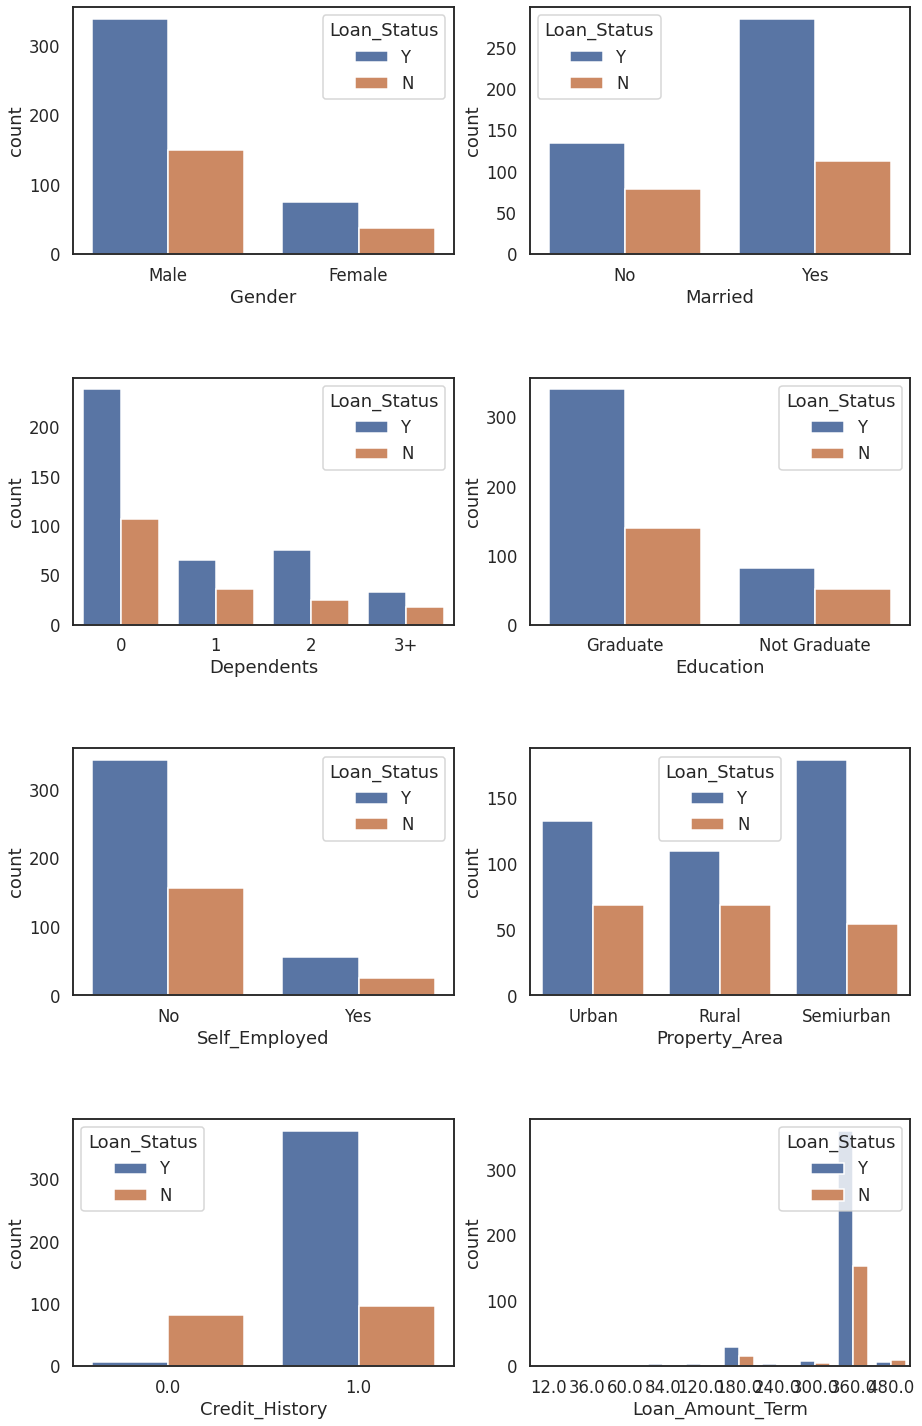

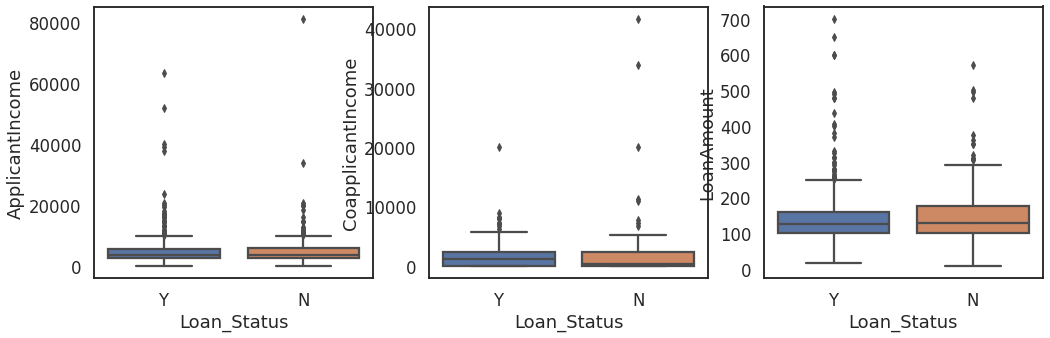

<Figure size 2160x1080 with 0 Axes>

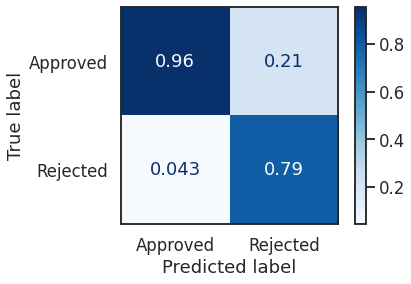

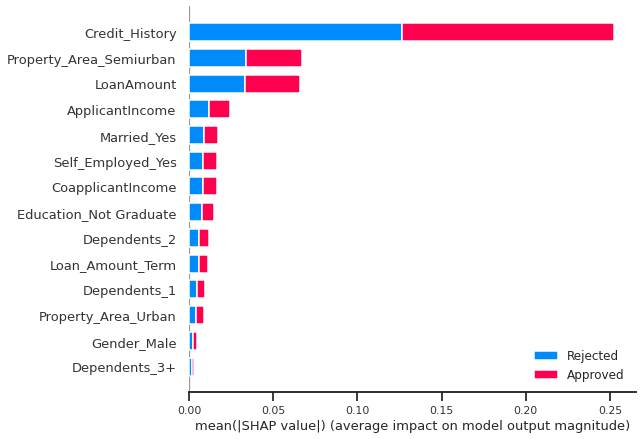

In [23]:
%cd /content/drift-detection-project/Loan Prediction Model
create_mlflow_run()